<a href="https://colab.research.google.com/github/jejjohnson/gp_model_zoo/blob/master/code/numpyro/exact_gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EGP (MCMC Schemes)

A demo notebook showing how solve a simple regression problem using an exact Gaussian Process (GP). This GP is trained with MLE and we will use the numpyro library as the backend for the inference.

In [1]:
# #@title Install Packages
# %%capture
# !pip install pyprojroot jax jaxlib chex numpyro flax distrax numpy pandas seaborn matplotlib corner loguru nb_black sklearn

In [2]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".root"])

# append to path
sys.path.append(str(root))

In [3]:
# @title Load Packages
# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union

# JAX SETTINGS
import jax
import jax.numpy as jnp
import jax.random as random
from jax.config import config

config.update("jax_enable_x64", True)


# JAX UTILITY LIBRARIES
import chex

# NUMPYRO SETTINGS
import numpyro
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoDiagonalNormal
from numpyro.infer import SVI, Trace_ELBO

# NUMPY SETTINGS
import numpy as np

np.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns

sns.set_context(context="poster", font_scale=0.8)

# PANDAS SETTINGS
import pandas as pd

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import loguru

%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [4]:
# ==========================
# INITIALIZE LOGGER
# ==========================
import wandb

wandb_logger = wandb.init(project="egp_1_1", entity="ipl_uv")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ml4floods (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [5]:
wandb.config.model = "sparse"
wandb.config.exp = "demo_1d"
wandb.config.n_train = 1_000
wandb.config.n_test = 1_000
wandb.config.x_noise = 0.3
wandb.config.y_noise = 0.01
wandb.config.seed = 123

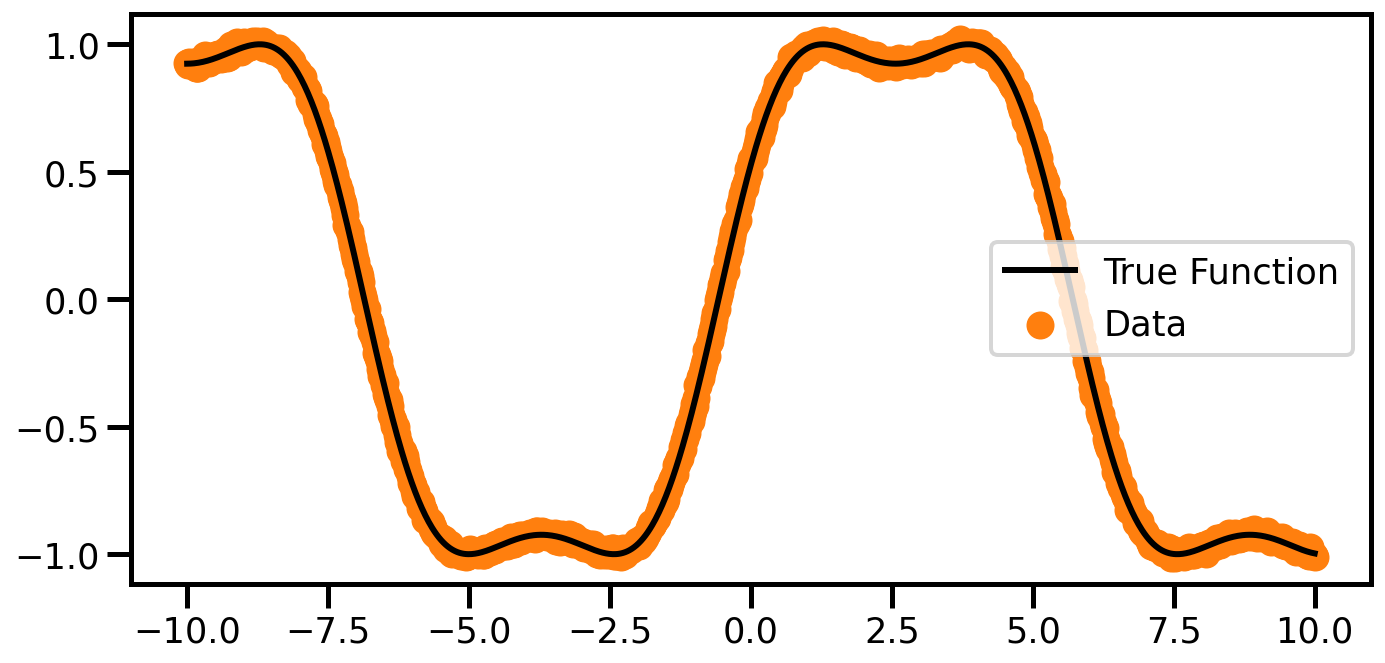

In [6]:
from src.data import regression_near_square

(
    Xtrain,
    Xtrain_noise,
    ytrain,
    xtest,
    xtest_noise,
    ytest,
    ytest_noise,
) = regression_near_square(
    n_train=1_000, n_test=1_000, x_noise=0.3, y_noise=0.01, seed=123, buffer=0.0
)

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(Xtrain, ytrain, color="tab:orange", label="Data")
ax.plot(xtest, ytest, color="black", label="True Function")
ax.legend()
plt.tight_layout()
plt.gcf()
wandb.log({"train_data_clean": wandb.Image(plt)})

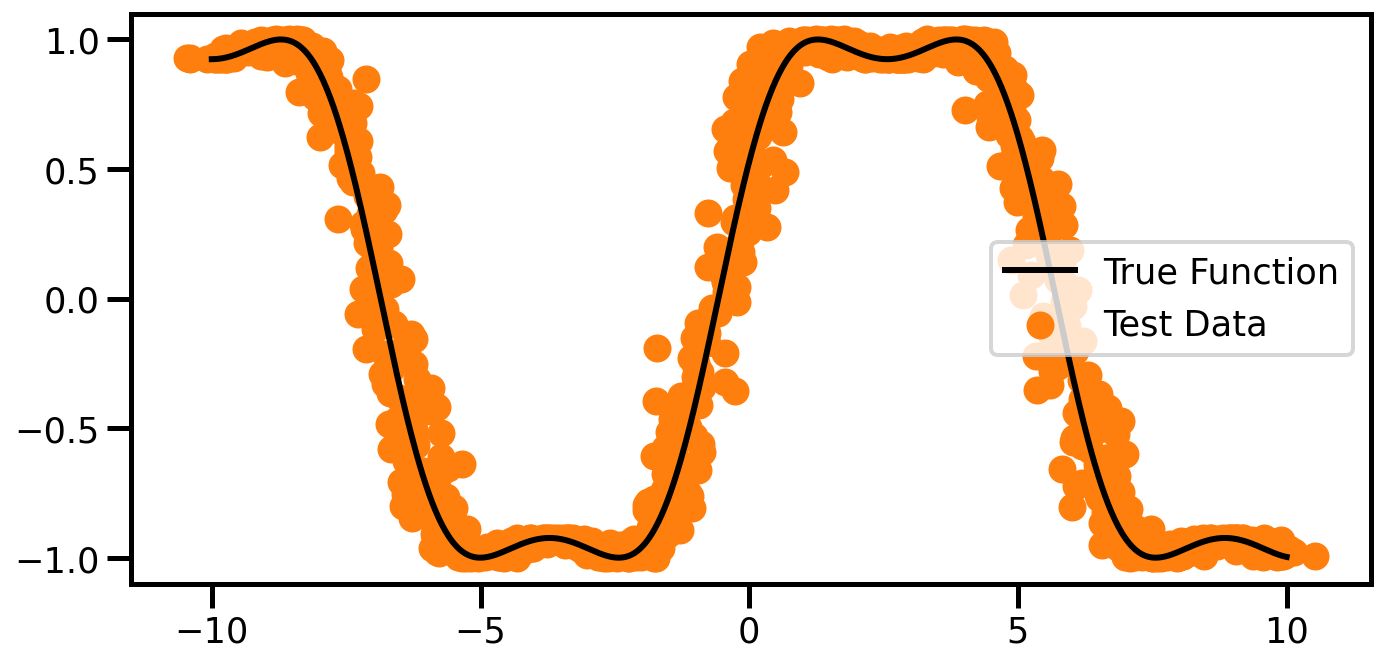

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(xtest_noise, ytest_noise, color="tab:orange", label="Test Data")
ax.plot(xtest, ytest, color="black", label="True Function")
ax.legend()
plt.tight_layout()
plt.gcf()
wandb.log({"test_data_noisy": wandb.Image(plt)})

## Gaussian Process Model

#### Kernel

In [8]:
from chex import Array
from src.utils import identity_matrix, add_to_diagonal
from src.kernels import RBF

rbf_kernel = RBF(length_scale=1.0, variance=1.0)
K = rbf_kernel.gram(Xtrain)

# check shape
chex.assert_shape(K, (Xtrain.shape[0], Xtrain.shape[0]))

#### Inducing Points

In [10]:
from src.utils import init_inducing_subsample, init_inducing_kmeans

n_inducing = 60

X_u_init = init_inducing_kmeans(Xtrain, n_inducing, seed=123)

### Model

In [11]:
from src.sparse import SGPVFE
from src.means import zero_mean
from chex import Array

jitter = 1e-5

inference = "map"
wandb.config.inference = inference


def numpyro_model(X, y):

    if inference == "map" or "vi_mf" or "vi_full":
        # Set priors on hyperparameters.
        η = numpyro.sample("variance", dist.HalfCauchy(scale=5.0))
        ℓ = numpyro.sample("length_scale", dist.Gamma(2.0, 1.0))
        σ = numpyro.sample("obs_noise", dist.HalfCauchy(scale=5.0))
    elif inference == "mll":

        # set params and constraints on hyperparams
        η = numpyro.param(
            "variance", init_value=1.0, constraints=dist.constraints.positive
        )
        ℓ = numpyro.param(
            "length_scale", init_value=1.0, constraints=dist.constraints.positive
        )
        σ = numpyro.param(
            "obs_noise", init_value=0.01, onstraints=dist.constraints.positive
        )
    else:
        raise ValueError(f"Unrecognized inference scheme: {inference}")

    x_u = numpyro.param("x_u", init_value=X_u_init)

    # Kernel Function
    rbf_kernel = RBF(variance=η, length_scale=ℓ)

    # GP Model
    gp_model = SGPVFE(
        X=X, X_u=x_u, y=y, mean=zero_mean, kernel=rbf_kernel, obs_noise=σ, jitter=jitter
    )

    # Sample y according SGP
    return gp_model.to_numpyro(y=y)


def empty_guide(X, y):
    pass

In [12]:
with numpyro.handlers.seed(rng_seed=123):
    t = numpyro_model(Xtrain, ytrain)

assert t.shape == Xtrain.shape

## Training (Maximum Likelihood)

In [13]:
from numpyro.infer.autoguide import (
    AutoDelta,
    AutoMultivariateNormal,
    AutoDiagonalNormal,
)

# ===================
# Model
# ===================
# GP model

# delta guide - basically deterministic


if inference == "map":
    guide = AutoDelta(numpyro_model)
elif inference == "vi_mf":
    guide = AutoDiagonalNormal(numpyro_model)
elif inference == "vi_full":
    guide = AutoMultivariateNormal(numpyro_model)
elif inference == "mll":

    def empty_guide(X, y):
        pass

    guide = empty_guide
else:
    raise ValueError(f"Unrecognized inference scheme: {inference}")

In [14]:
# reproducibility
rng_key = random.PRNGKey(0)


# Setup
wandb.config.step_size = 0.01
wandb.config.train_seed = 42
wandb.config.iterations = 2_500

optimizer = numpyro.optim.Adam(step_size=0.01)
# optimizer = numpyro.optim.Minimize()
# optimizer = optax.adamw(learning_rate=0.1)
svi = SVI(numpyro_model, guide, optimizer, loss=Trace_ELBO())
svi_results = svi.run(random.PRNGKey(1), 2_500, Xtrain, ytrain.T)

100%|██████████| 2500/2500 [00:19<00:00, 126.76it/s, init loss: 2006.3395, avg. loss [2376-2500]: -3061.2070]


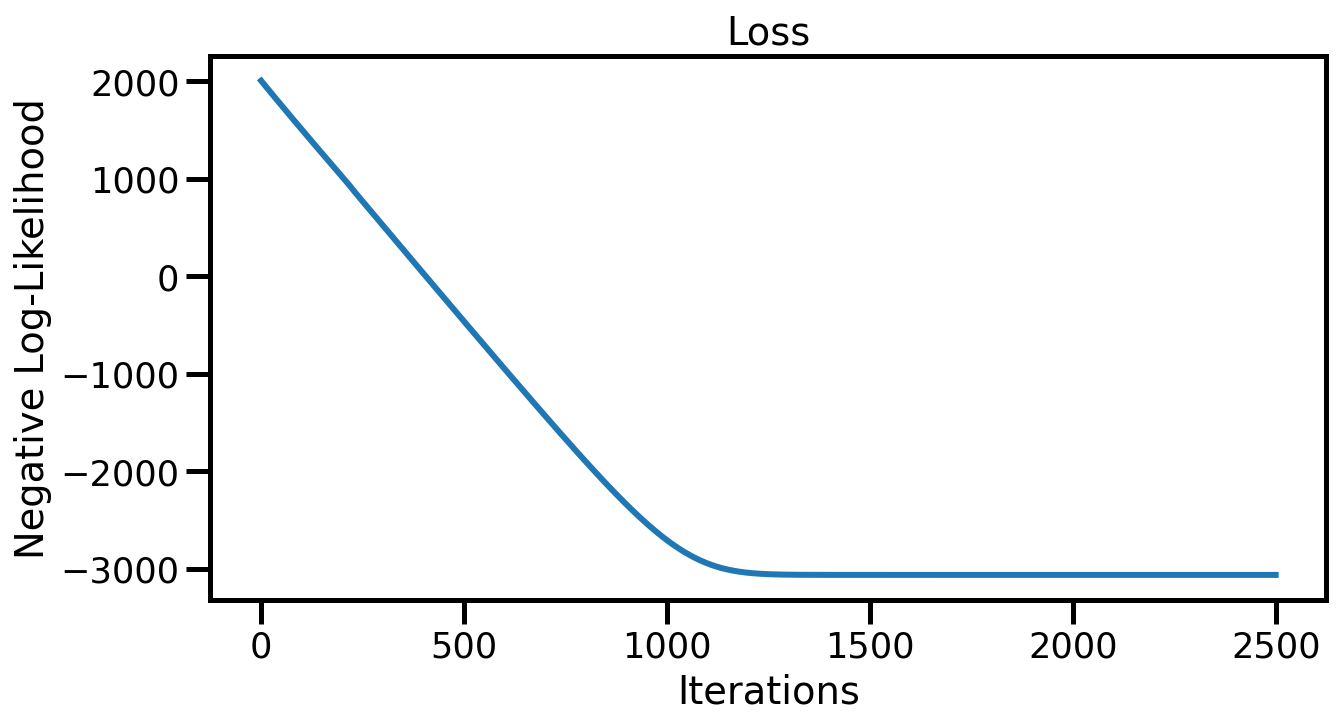

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(svi_results.losses)
ax.set(title="Loss", xlabel="Iterations", ylabel="Negative Log-Likelihood")
plt.gcf()
wandb.log({"loss": wandb.Image(plt)})

### Extracting the Params

In [16]:
import numpy as np

In [17]:
from pprint import pprint

# Take them directly
learned_params = svi_results.params
# pprint(learned_params)

if inference != "mll":
    x_u = learned_params["x_u"]
    learned_params = guide.median(learned_params)
    learned_params["x_u"] = x_u


# wandb.log({"x_u": np.array(x_u)})
# pprint(learned_params)

### Predictions

In [18]:
from src.sparse import init_sgp_predictive

sgp_pred = init_sgp_predictive(RBF, learned_params, Xtrain, ytrain, jitter=1e-5)

mu, var = sgp_pred.predict_y(xtest)

std = jnp.sqrt(var.squeeze())

In [19]:
ci = 1.96
one_stddev = ci * std

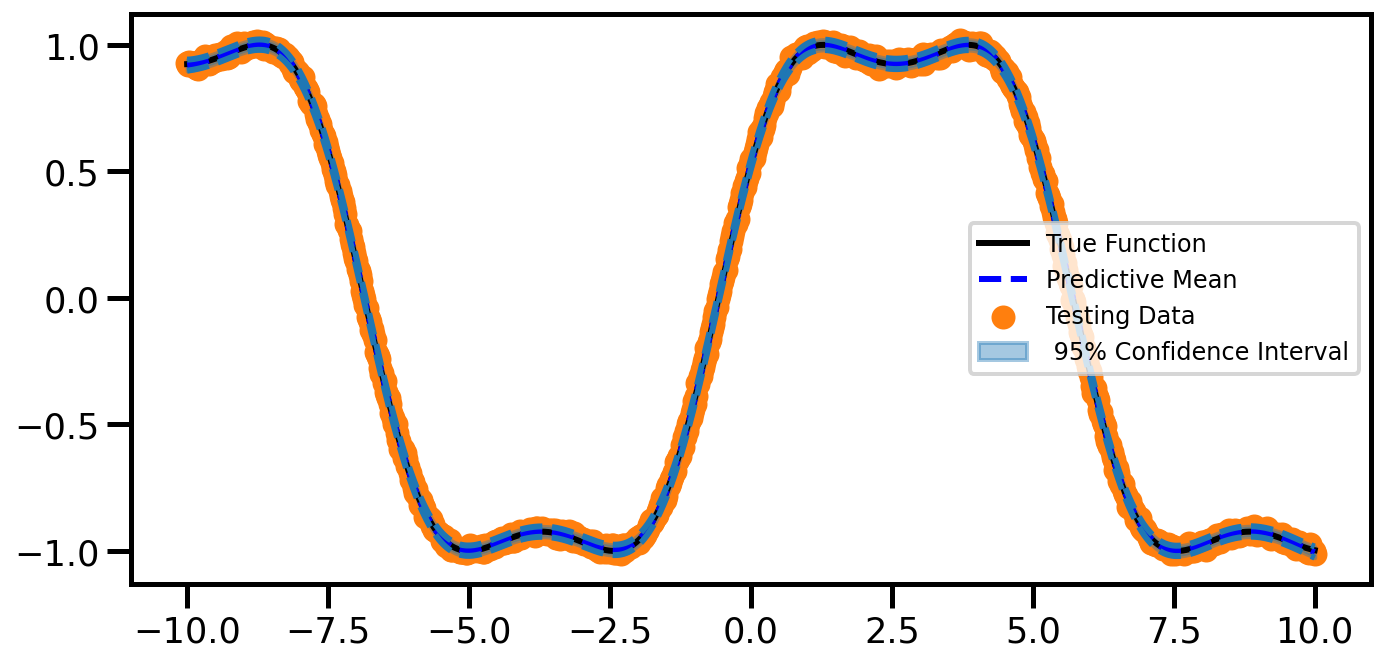

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(Xtrain, ytrain, marker="o", s=100, color="tab:orange", label="Testing Data")
ax.plot(xtest, ytest, color="black", linestyle="-", label="True Function")
ax.plot(
    xtest,
    mu.ravel(),
    color="Blue",
    linestyle="--",
    linewidth=3,
    label="Predictive Mean",
)
ax.fill_between(
    xtest.ravel(),
    mu.ravel() - one_stddev,
    mu.ravel() + one_stddev,
    alpha=0.4,
    color="tab:blue",
    label=f" 95% Confidence Interval",
)
ax.plot(xtest, mu.ravel() - one_stddev, linestyle="--", color="tab:blue")
ax.plot(xtest, mu.ravel() + one_stddev, linestyle="--", color="tab:blue")
plt.tight_layout()
plt.legend(fontsize=12)
plt.gcf()
wandb.log({"esgp_pred_standard_clean": wandb.Image(plt)})

## Calibration

In [21]:
from uncertainty_toolbox import viz as utviz

#### Test Data

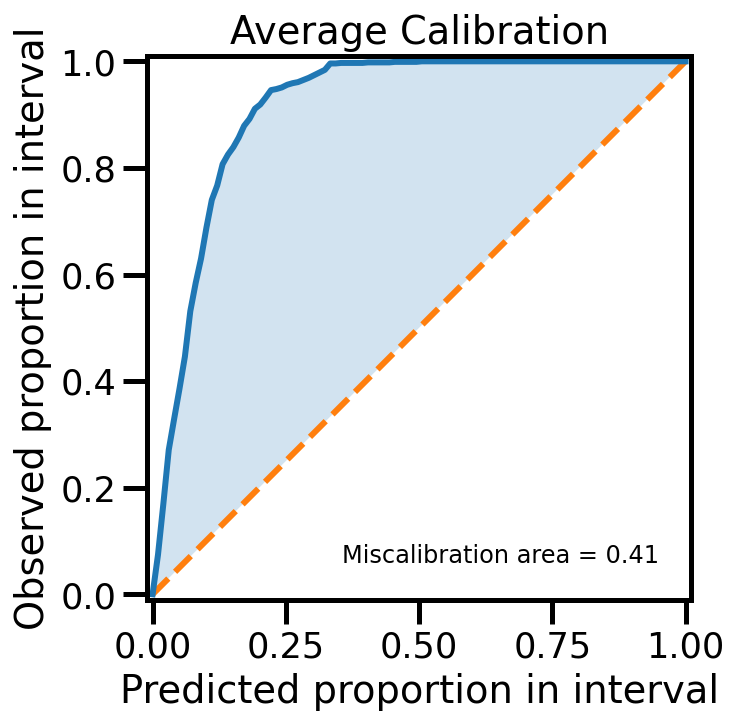

In [22]:
mu, var = sgp_pred.predict_y(xtest)

std = jnp.sqrt(var.squeeze())

utviz.plot_calibration(y_pred=mu.ravel(), y_std=std.ravel(), y_true=ytest.ravel())
plt.gcf()
wandb.log({"esgp_calib_standard_clean": wandb.Image(plt)})

## Noisy Test Data

In [23]:
mu, var = sgp_pred.predict_y(xtest_noise)

std = jnp.sqrt(var.squeeze())

ci = 1.96
one_stddev = ci * std

In [24]:
idx_samples = np.random.choice(np.arange(xtest_noise.shape[0]), 50)

In [25]:
def plot_noisy_predictions(mu, var, method):
    std = jnp.sqrt(var.squeeze())
    ci = 1.96
    one_stddev = ci * std
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.scatter(
        xtest_noise,
        ytest_noise,
        marker="o",
        s=30,
        color="tab:orange",
        label="Testing Data",
    )
    ax.plot(xtest, ytest, color="black", linestyle="-", label="True Function")
    ax.plot(
        xtest_noise,
        mu.ravel(),
        color="Blue",
        linestyle="--",
        linewidth=3,
        label="Predictive Mean",
    )
    ax.fill_between(
        xtest_noise.ravel(),
        mu.ravel() - one_stddev,
        mu.ravel() + one_stddev,
        alpha=0.4,
        color="tab:blue",
        label=f" 95% Confidence Interval",
    )
    ax.plot(xtest_noise, mu.ravel() - one_stddev, linestyle="--", color="tab:blue")
    ax.plot(xtest_noise, mu.ravel() + one_stddev, linestyle="--", color="tab:blue")
    plt.tight_layout()
    plt.legend(fontsize=12)
    plt.gcf()
    wandb.log({f"esgp_pred_{method}_noisy": wandb.Image(plt)})

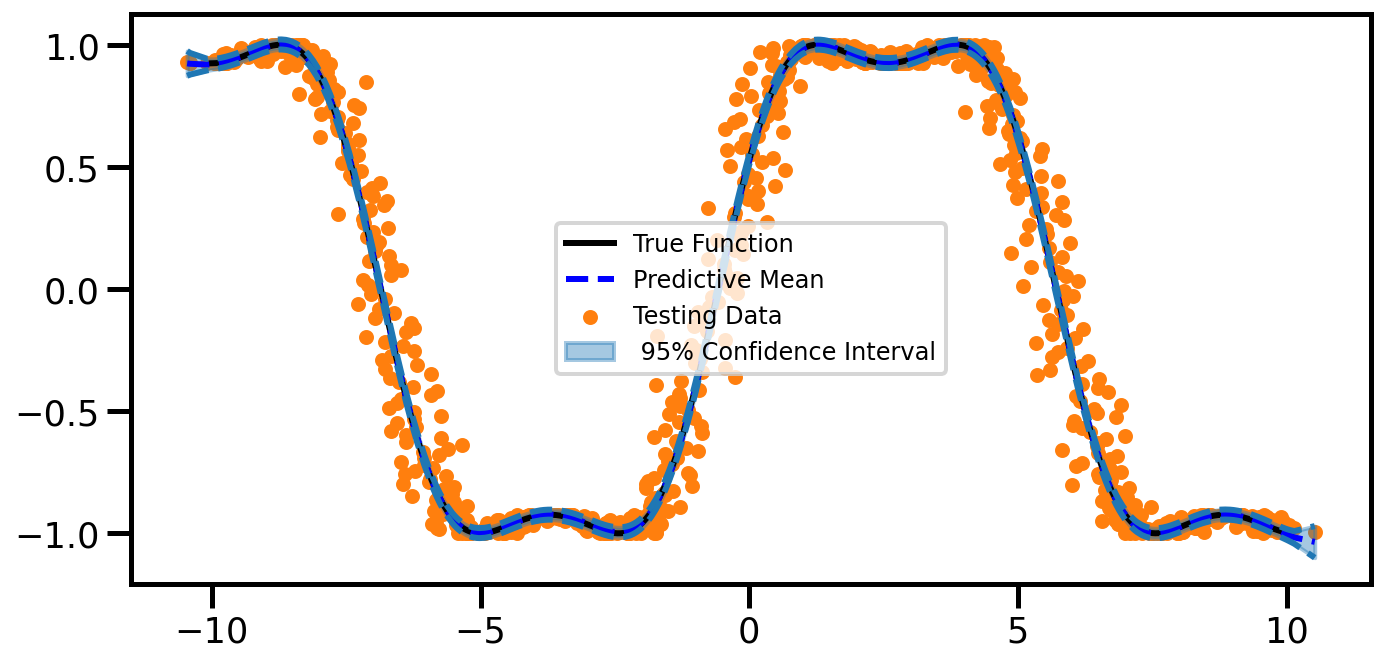

In [26]:
plot_noisy_predictions(mu, var, "standard")

In [27]:
def plot_calibrations(mu, var, method):
    std = jnp.sqrt(var.squeeze())
    ci = 1.96
    one_stddev = ci * std
    utviz.plot_calibration(
        y_pred=mu.ravel(), y_std=std.ravel(), y_true=ytest_noise.ravel()
    )
    plt.gcf()
    wandb.log({f"esgp_calib_{method}_noisy": wandb.Image(plt)})

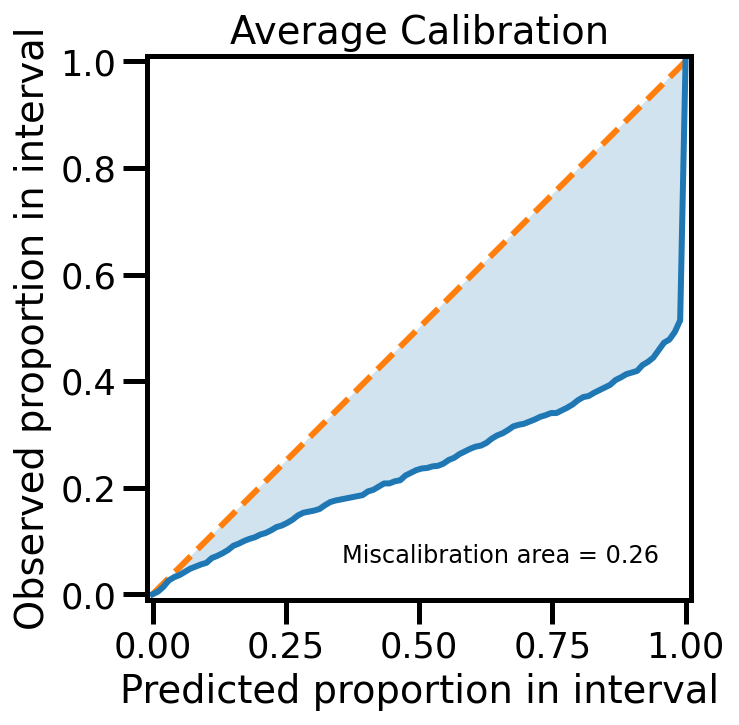

In [28]:
plot_calibrations(mu, var, "standard")

## Input Distribution

In [29]:
x_scale = jnp.array([0.3])
x_cov = x_scale.reshape(-1, 1) ** 2

## Monte Carlo Samples

In this first example, we will approximate the actual posterior using Monte Carlo sampling. Using the following formula:

$$
p(f_*|\mu_\mathbf{x}, \Sigma_\mathbf{x}, \mathcal{D}) \approx \frac{1}{T}\sum_{t=1}^T \mathcal{N}\left(f_*|\mu_\mathcal{GP}(\mathbf{x}_*^t),\sigma^2_\mathcal{GP}(\mathbf{x}_*^t) \right) 
$$

This will approach the real posterior as $T$ grows. What we want to demonstrate is that this posterior is non-Gaussian when our inputs are non-Gaussian.

In this example, we assume that $\mathbf{x}_* \sim \mathcal{N}(\mathbf{\mu_x}, \mathbf{\Sigma_x})$. We're assuming our data points come We can reparameterize this as f


we will be using the following form to do the sampling:

$$
\mathbf{x}_T = \mu_\mathbf{x} + \mathbf{L}\mathbf{z}
$$

where $\mathbf{z}\sim \mathcal{N}(\mathbf{0}, \mathbf{I})$. So we will draw 10,000 samples and then propagate all of these through the non-linear function.

In [30]:
from src.uncertain.monte_carlo import MCTransform

In [32]:
from src.uncertain.monte_carlo import init_mc_transform

egp_pred_mc = MCTransform(sgp_pred, n_samples=1_000, cov_type="diag")
key = jax.random.PRNGKey(123)

mu_mc, var_mc = egp_pred_mc.predict_f(key, xtest_noise, x_scale, False)
std_mc = jnp.sqrt(var_mc).ravel()
assert mu_mc.shape == var_mc.shape

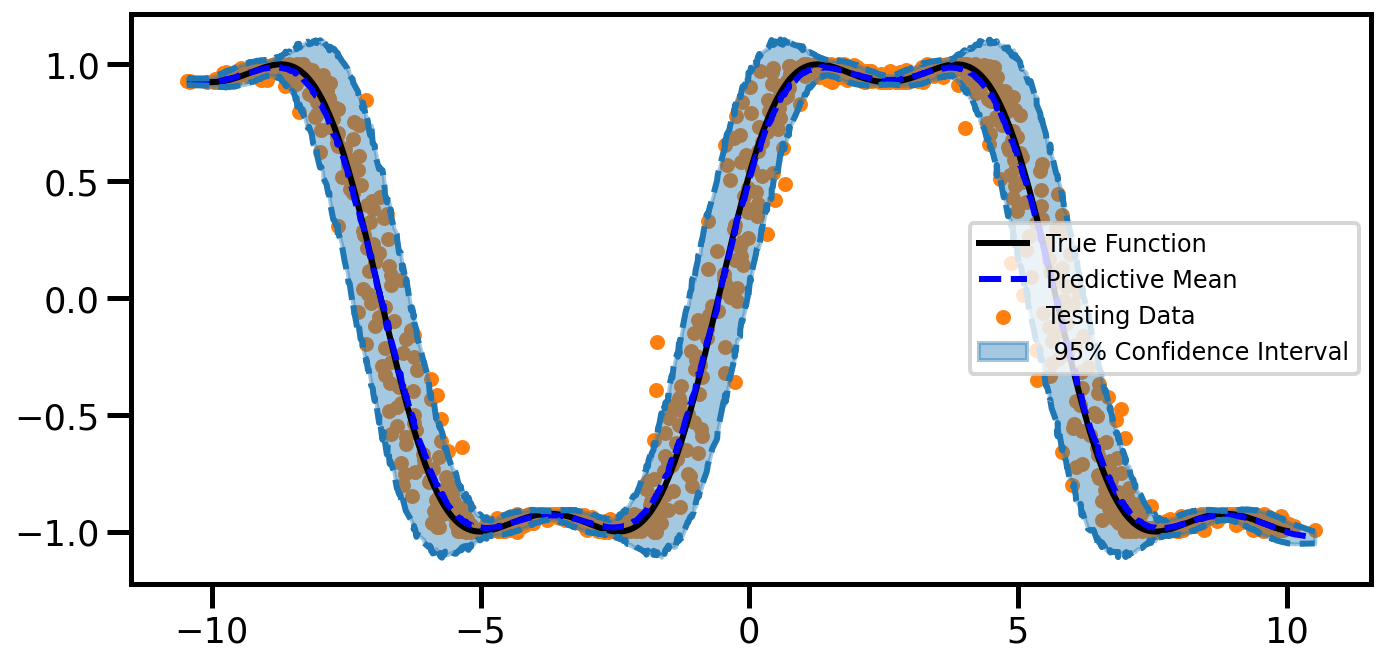

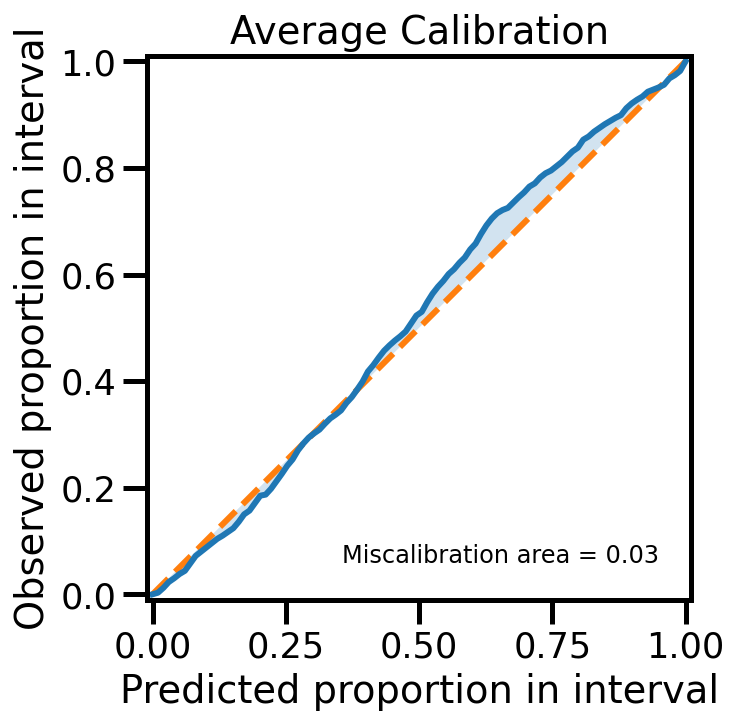

In [33]:
plot_noisy_predictions(mu_mc, var_mc, "mc")
plot_calibrations(mu_mc, var_mc, "mc")

In [34]:
mu_mc, cov_mc = egp_pred_mc.predict_f(key, xtest_noise, x_scale, True)

In [35]:
import tensorflow_probability.substrates.jax as tfp

dist = tfp.distributions
pred_dist = dist.MultivariateNormalFullCovariance(
    loc=mu_mc.squeeze(),
    covariance_matrix=cov_mc.squeeze() + 1e-9 * jnp.eye(cov_mc.shape[0]),
)

In [36]:
samples = pred_dist.sample(sample_shape=(100,), seed=key)

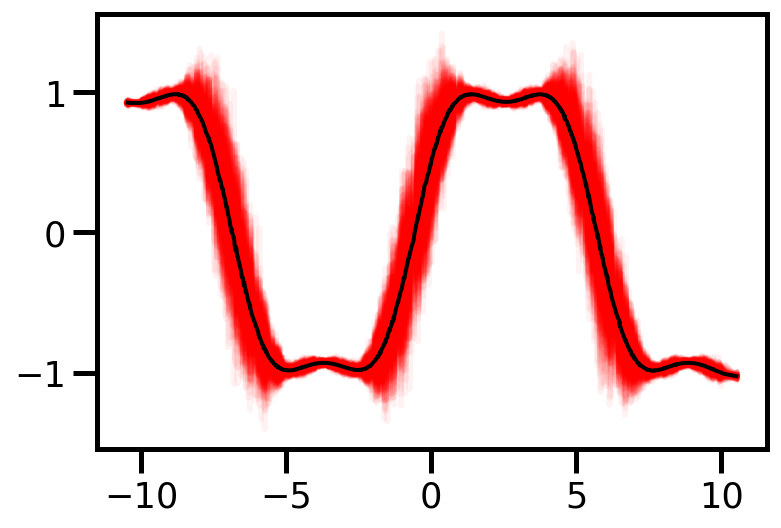

In [37]:
plt.figure()
plt.plot(xtest_noise.ravel(), samples.T, alpha=0.05, color="red")
plt.plot(xtest_noise.ravel(), mu_mc.ravel(), color="black", linewidth=2)
plt.show()

## Sigma Points

### Unscented Transformation

In [38]:
from src.uncertain.unscented import UnscentedTransform

In [41]:
egp_pred_unc = UnscentedTransform(sgp_pred, n_features=1)

mu_unc, var_unc = egp_pred_unc.predict_f(xtest_noise, x_cov, False)
std_unc = jnp.sqrt(var_unc.squeeze())

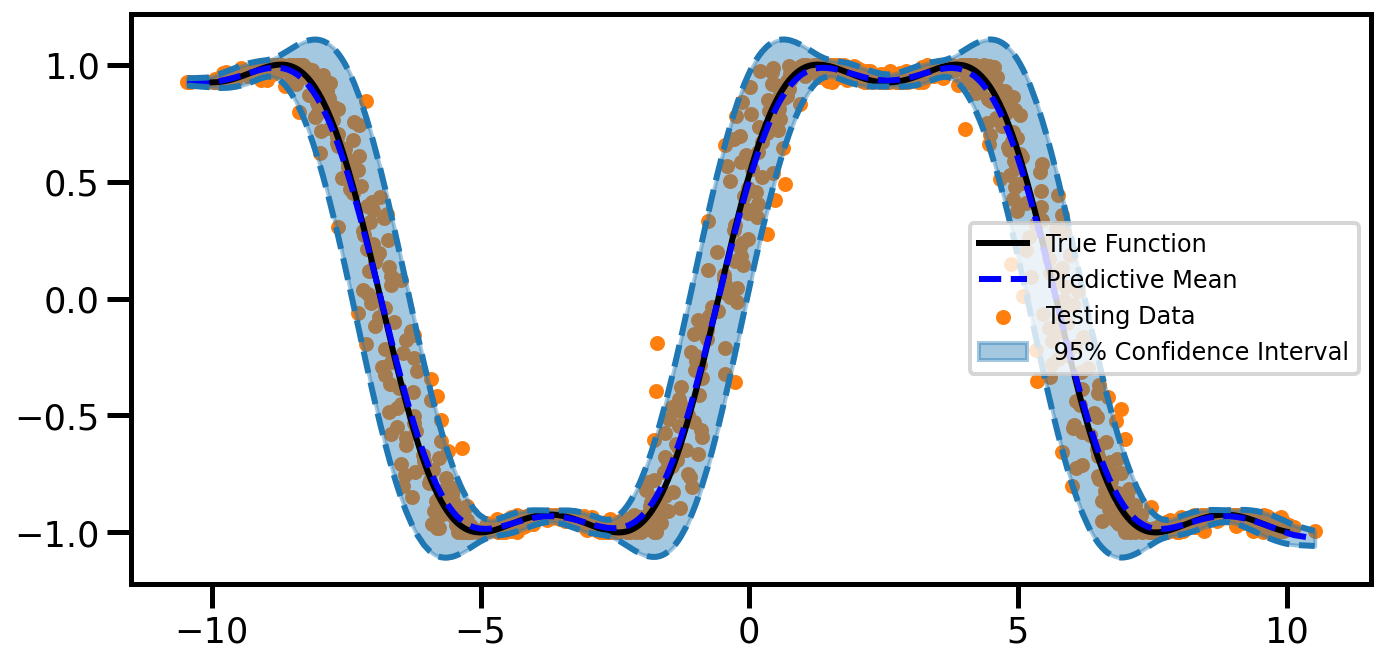

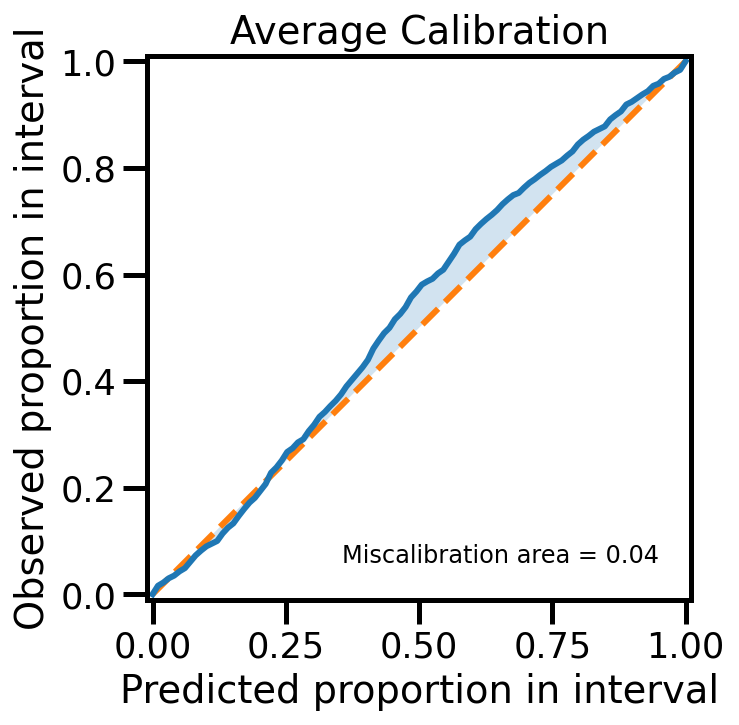

In [42]:
plot_noisy_predictions(mu_unc, var_unc, "unscented")
plot_calibrations(mu_unc, var_unc, "unscented")

In [43]:
mu_mc, cov_var = egp_pred_unc.predict_f(xtest_noise, x_cov, True)

In [44]:
pred_dist = dist.MultivariateNormalFullCovariance(
    loc=mu_mc.squeeze(),
    covariance_matrix=cov_var.squeeze() + 1e-8 * jnp.eye(cov_var.shape[0]),
)

In [45]:
samples = pred_dist.sample(sample_shape=(100,), seed=key)

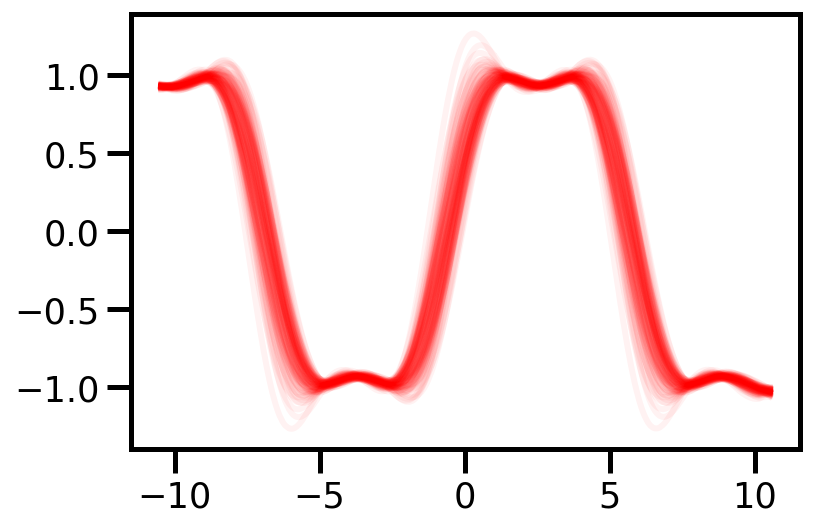

In [46]:
plt.figure()
plt.plot(xtest_noise.ravel(), samples.T, alpha=0.05, color="red")
plt.show()

### Unscented Transform (Spherical Radial)

In [47]:
from src.uncertain.unscented import SphericalTransform

In [49]:
egp_pred_unc_sph = UnscentedTransform(sgp_pred, n_features=1)

mu_unc_sph, var_unc_sph = egp_pred_unc_sph.predict_f(xtest_noise, x_cov, False)
std_unc_sph = jnp.sqrt(var_unc_sph.squeeze())

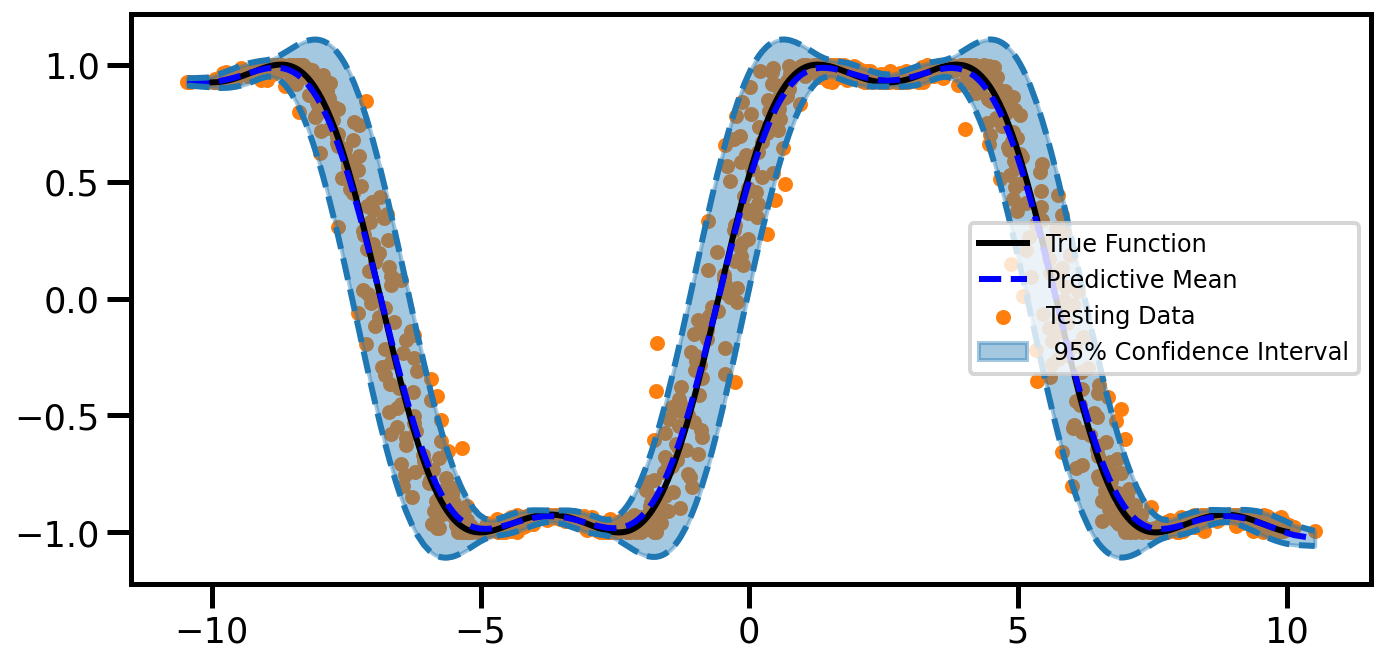

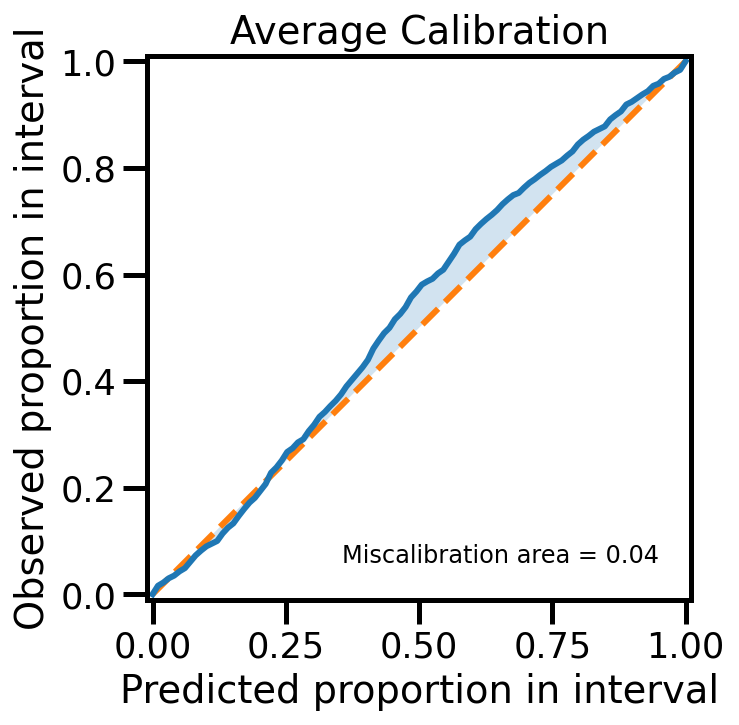

In [50]:
plot_noisy_predictions(mu_unc_sph, var_unc_sph, "unc_sph")
plot_calibrations(mu_unc_sph, var_unc_sph, "unc_sph")

### Gauss-Hermite

In [52]:
from src.uncertain.quadrature import GaussHermiteTransform


egp_pred_gh = GaussHermiteTransform(sgp_pred, n_features=1, degree=3)

mu_gh, var_gh = egp_pred_gh.predict_f(xtest_noise, x_cov, False)
std_gh = jnp.sqrt(var_gh.squeeze())

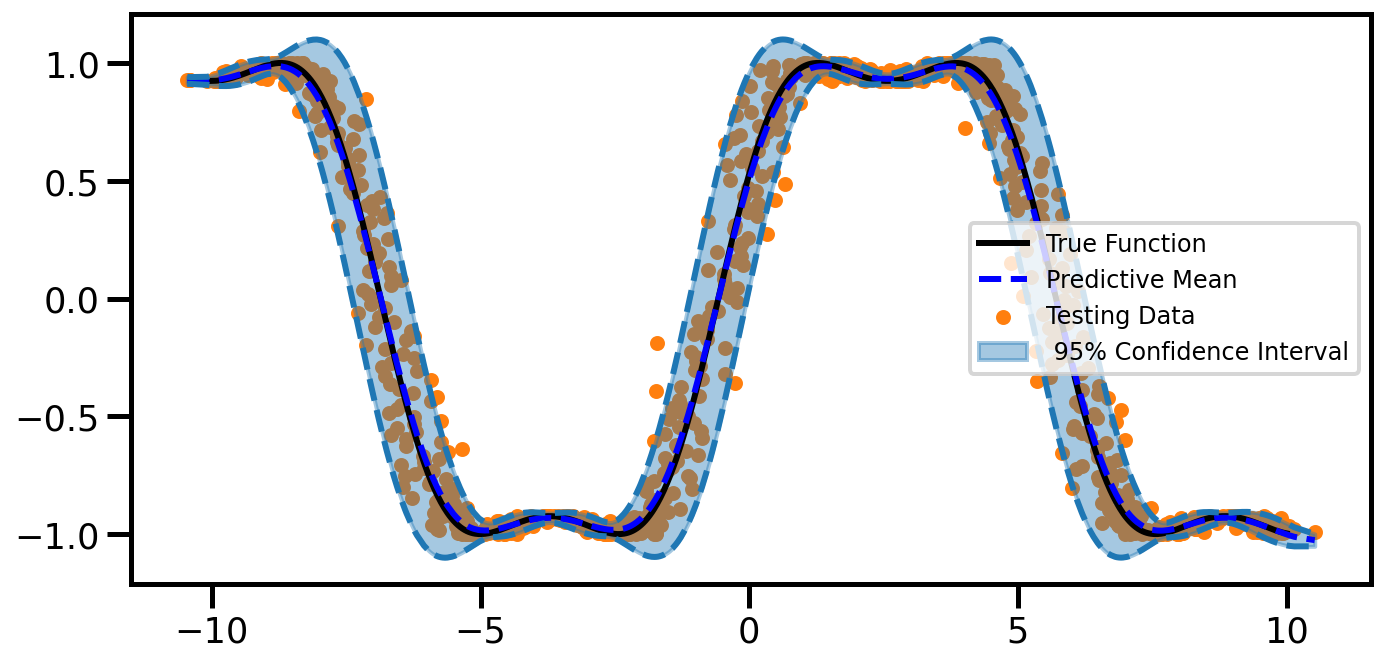

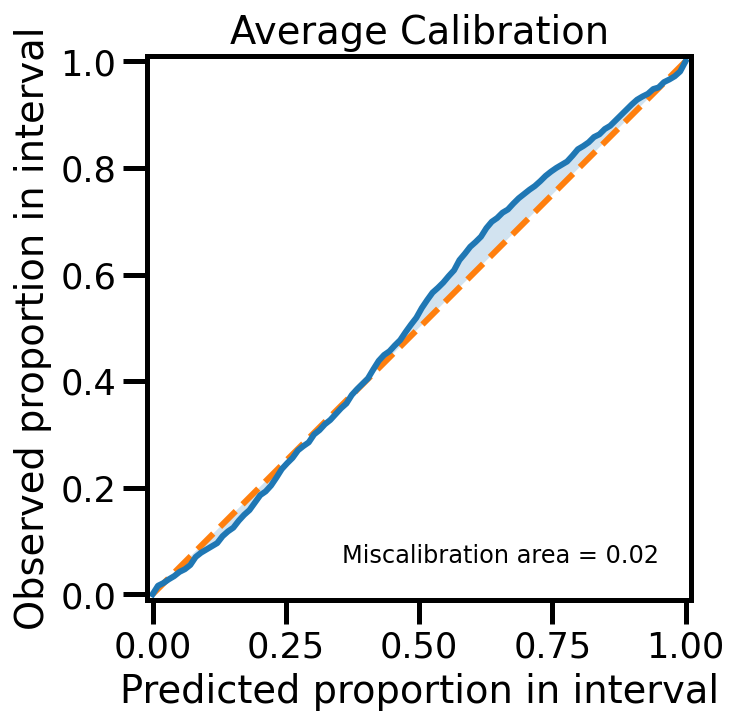

In [53]:
plot_noisy_predictions(mu_gh, var_gh, "gh")
plot_calibrations(mu_gh, var_gh, "gh")